## 手書き数字認識の実装


In [1]:
import sys, os

sys.path.append("../deep-learning-from-scratch-master")
from dataset.mnist import load_mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle

### MNIST データ

MNIST データについて

- 訓練画像が 60000 枚、テスト画像が 10000 枚
- 28×28 のグレースケール画像で、各ピクセルは 0〜255 の値

`load_mnist`関数

- `flatten=True`とした場合、784 個の要素からなる１次元配列を返す。
- `normalize=True`とした場合、ピクセルの値を 255 で割って 0〜1 の範囲に変換される。


In [2]:
# MNISTデータを読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# それぞれのデータの形状を出力
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
(60000, 784)
(60000,)
(10000, 784)
(10000,)


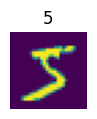

In [3]:
# 読み込んだ画像を表示する
def imgShow(img: np.ndarray, title: str = ""):
    pilImg = Image.fromarray(np.uint8(img))
    plt.figure(figsize=(1, 1))
    im = plt.imshow(pilImg)
    plt.axis("off")
    plt.title(title)
    plt.show()


# 試しに訓練画像の１枚目を表示してみる
img = x_train[0].reshape(28, 28)
imgShow(img=img, title=f"{t_train[0]}")

### ネットワークの構造を定義

- ３層のネットワーク
- 入力層のニューロンは $28^2 = 784$ 個
- １つ目の隠れ層のニューロンは 50 個
- ２つ目の隠れ層のニューロンは 100 個
  - これらの値は任意性がある
- 出力層のニューロンは 10 個（10 クラス分類なので）

$$
\underbrace{X}_{784} \quad \underbrace{W_1}_{784 \times 50} \quad \underbrace{W_2}_{50 \times 100} \quad \underbrace{W_3}_{100 \times 10} = \underbrace{Y}_{10}
$$


In [4]:
# サンプルとして配布されている重み付きのネットワークを取得する
def initNetwork():
    with open("../deep-learning-from-scratch-master/ch03/sample_weight.pkl", "rb") as f:
        network = pickle.load(f)
    return network

In [5]:
# 活性化関数の定義
def sigmoid(x: np.ndarray):
    return 1 / (1 + np.exp(-x))


# softmax関数の定義
def softmax(a: np.ndarray) -> np.ndarray:
    c = np.max(a)
    exp_a = np.exp(a - c)
    y = exp_a / np.sum(exp_a)
    return y

In [6]:
# 入力信号を出力に変換するプロセスをまとめて実装した関数
def predict(network, x: np.ndarray):
    W1, W2, W3 = network["W1"], network["W2"], network["W3"]
    b1, b2, b3 = network["b1"], network["b2"], network["b3"]

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

### 精度の検証


In [7]:
# MNISTデータを（正規化して）読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True)

# 重み付きのネットワークを作成
network = initNetwork()

# 正解数
correctCount = 0

# テストデータをすべて予測し、正解率を計測する
for i in range(len(x_test)):

    # 与えられたネットワークによって、テスト画像の数値を予測
    y = predict(network=network, x=x_test[i])

    # yの最大値のインデックスを取得
    prediction = np.argmax(y)

    # 正解していたら記録
    if prediction == t_test[i]:
        correctCount += 1

print(f"Accuracy: {float(correctCount) / len(x_test)}")

Accuracy: 0.9352


### バッチ処理

例：100 枚分のデータをまとめて処理

$$
\underbrace{X}_{100 \times 784} \quad \underbrace{W_1}_{784 \times 50} \quad \underbrace{W_2}_{50 \times 100} \quad \underbrace{W_3}_{100 \times 10} = \underbrace{Y}_{100 \times 10}
$$


In [8]:
# MNISTデータを（正規化して）読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True)

# 重み付きのネットワークを作成
network = initNetwork()

# バッチの数
batchSize = 100

# 正解数
correctCount = 0

# テストデータをすべて予測し、正解率を計測する
for i in range(0, len(x_test), batchSize):

    # 100個分のデータをまとめた行列
    x_batch = x_test[i : i + batchSize]

    # バッチ処理によって一度にpredict
    y_batch = predict(network=network, x=x_batch)

    # yの最大値のインデックスを100個分まとめて取得
    prediction = np.argmax(y_batch, axis=1)

    # 正解していたら記録
    correctCount += np.sum(prediction == t_test[i : i + batchSize])

print(f"Accuracy: {float(correctCount) / len(x_test)}")

Accuracy: 0.9352
